In [2]:
%load_ext autoreload
%autoreload 2

# Setup Paths

In [3]:
import os
import pyrootutils
root = pyrootutils.setup_root(
    search_from='.',
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)
hydra_cfg_path = root / "text_classification_problems" / "configs"
os.chdir(root / "text_classification_problems")

In [4]:
import hydra
from hydra import compose, initialize

from pathlib import Path
import numpy as np
import torch
from core.grads import tree_to_device
from core.tracer import KNN, KNNGD, KNNGN
from sklearn.neighbors import KNeighborsClassifier
from text_classification_problems.datamodule import TextClassifierDataModule
from text_classification_problems.modelmodule import TextClassifierModel
from transformers import AutoTokenizer
from tqdm import tqdm

import matplotlib.pyplot as plt

/host/ThangND34/ErrorDetection/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config  

In [5]:
'..' / hydra_cfg_path.relative_to(root)
with initialize(version_base=None, config_path= '../configs'):
    cfg = compose(config_name="tracing", return_hydra_config=True, overrides=["datamodule=imdb", "tracer=gd"])

In [6]:
device = 'cuda:2'

# Load Data and Model

In [7]:
from datamodule import TextClassifierDataModule

In [8]:
checkpoint = torch.load("outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=01_val_acc=0.8803.ckpt", map_location=device)
datamodule_hparams = checkpoint["datamodule_hyper_parameters"] 

In [9]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
dm = TextClassifierDataModule(
    data_root=os.environ["PYTORCH_DATASET_ROOT"],
    tokenizer=tokenizer,
    **datamodule_hparams,
    use_denoised_data=True
)
dm.prepare_data()
dm.setup("tracing")

In [10]:
net = hydra.utils.instantiate(cfg.net, num_classes=dm.num_classes)
lit_model = TextClassifierModel(
    net=net,
    num_classes=dm.num_classes,
    lr=1e-3,
)
net = lit_model.net
lit_model.eval()
lit_model.to(device);

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Stats

In [11]:
from core.grads import RuntimeGradientExtractor
from core.tracer import GradientNormalize as GN, GradientCosin as GC, GradientBasedTracer as GD
import torch.nn.functional as F
import pandas as pd
from core.aggregation import cal_neibor_matrices
from text_classification_problems.convert_result import eval_ckpt
from text_classification_problems.run_tracing import register_BatchEncoding
import re
from core.eval import cal_precision_top
from core.mrr import compute_mean_reciprocal_rank

In [12]:
register_BatchEncoding()

## Collecting

In [13]:
def get_self_confidence_for_each_label(
    labels: np.array,
    pred_probs: np.array,
) -> np.array:
    label_quality_scores = np.array([np.mean(pred_probs[i, l]) for i, l in enumerate(labels)])
    return label_quality_scores


def get_normalized_entropy(pred_probs: np.ndarray, min_allowed_prob: float = 1e-6) -> np.ndarray:
    num_classes = pred_probs.shape[1]

    # Note that dividing by log(num_classes) changes the base of the log which rescales entropy to 0-1 range
    clipped_pred_probs = np.clip(pred_probs, a_min=min_allowed_prob, a_max=None)
    return -np.sum(pred_probs * np.log(clipped_pred_probs), axis=1) / np.log(num_classes)



In [14]:
ref_loader = dm.ref_dataloader()
trace_loader = dm.trace_dataloader()
true_error_labels = torch.isin(torch.arange(len(dm.trace_set)), dm.flipped_inds)

100%|██████████| 21/21 [00:02<00:00,  7.40it/s]


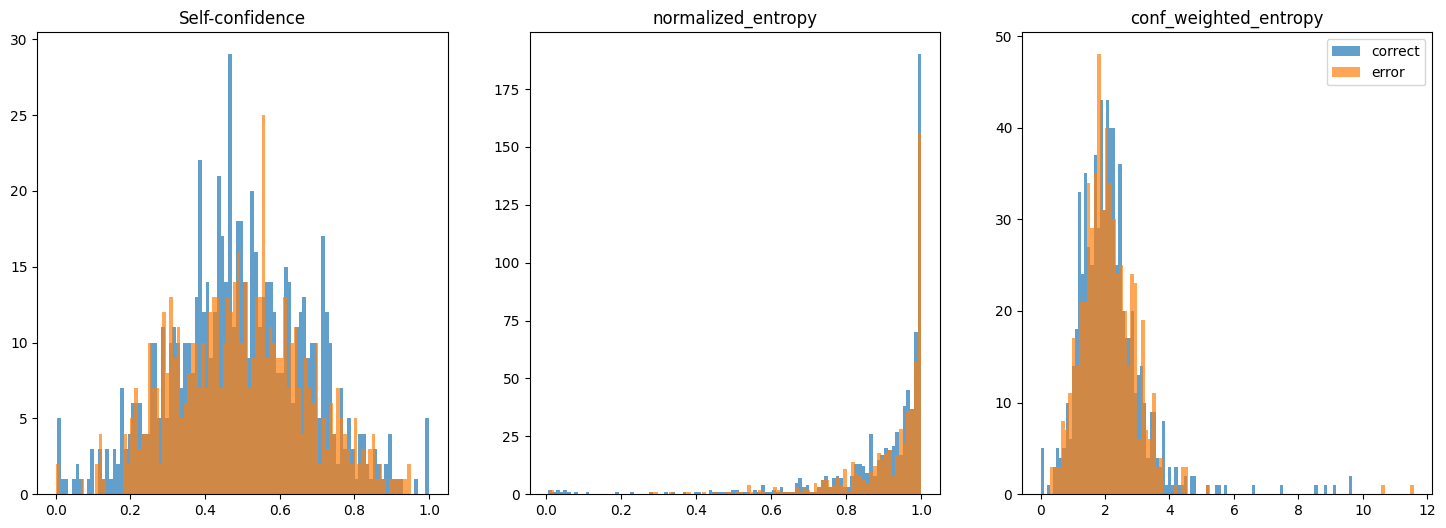

In [15]:
lit_model.to(device)
lit_model.eval()
labels = []
probs = []
with torch.no_grad():
    for batch in tqdm(trace_loader):
        batch = tree_to_device(batch, device)
        logits = lit_model.forward(batch)
        probs.append(torch.softmax(logits, dim=-1).cpu())
        labels.append(batch['label'].cpu())
    probs = torch.concat(probs).numpy()
    labels = torch.concat(labels).numpy()

normalized_entropy = get_normalized_entropy(probs)
self_confidence = torch.tensor(get_self_confidence_for_each_label(labels, probs))
conf_weighted_entropy = normalized_entropy / self_confidence

fig, axes = plt.subplots(1,3, figsize=(18, 6))
axes[0].hist(self_confidence[true_error_labels], bins=100, label='correct', alpha=0.7)
axes[0].hist(self_confidence[~true_error_labels], bins=100, label='error', alpha=0.7)
axes[0].set_title("Self-confidence")
axes[1].hist(normalized_entropy[true_error_labels], bins=100, label='correct', alpha=0.7)
axes[1].hist(normalized_entropy[~true_error_labels], bins=100, label='error', alpha=0.7)
axes[1].set_title("normalized_entropy")
axes[2].hist(conf_weighted_entropy[true_error_labels], bins=100, label='correct', alpha=0.7)
axes[2].hist(conf_weighted_entropy[~true_error_labels], bins=100, label='error', alpha=0.7)
axes[2].set_title("conf_weighted_entropy")
plt.legend()

100%|██████████| 21/21 [00:01<00:00, 10.55it/s]


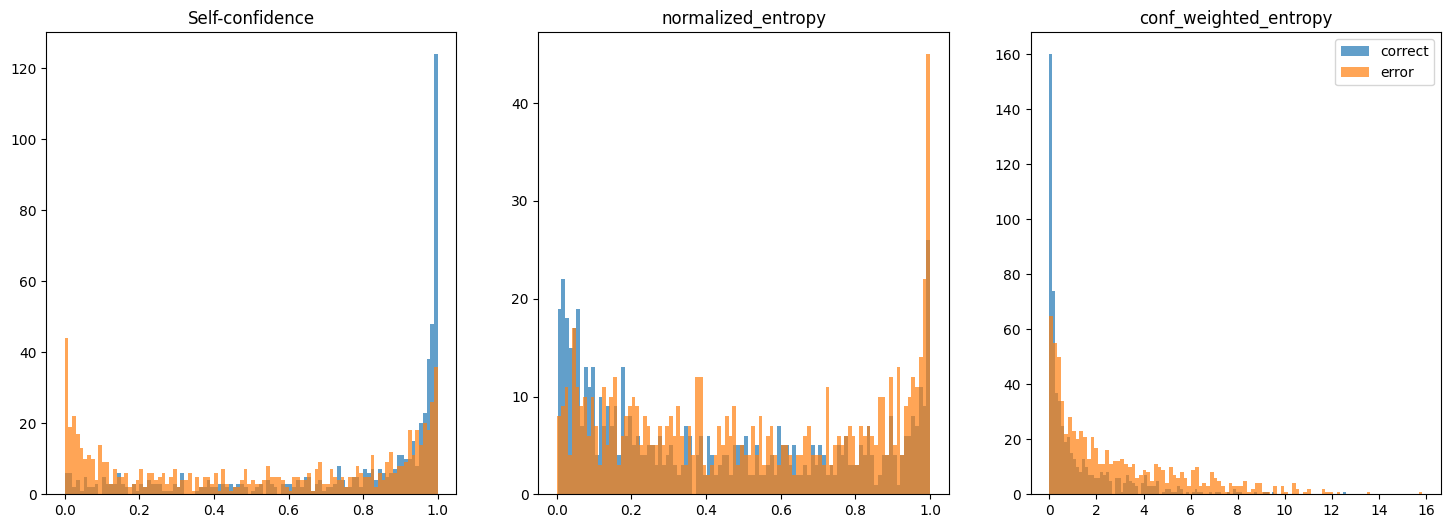

In [16]:
lit_model.load_state_dict(checkpoint["state_dict"])
lit_model.to(device)
lit_model.eval()
labels = []
probs = []
with torch.no_grad():
    for batch in tqdm(trace_loader):
        batch = tree_to_device(batch, device)
        logits = lit_model.forward(batch)
        probs.append(torch.softmax(logits, dim=-1).cpu())
        labels.append(batch['label'].cpu())
    probs = torch.concat(probs).numpy()
    labels = torch.concat(labels).numpy()

normalized_entropy = get_normalized_entropy(probs)
self_confidence = torch.tensor(get_self_confidence_for_each_label(labels, probs))
conf_weighted_entropy = normalized_entropy / self_confidence

fig, axes = plt.subplots(1,3, figsize=(18, 6))
axes[0].hist(self_confidence[~true_error_labels], bins=100, label='correct', alpha=0.7)
axes[0].hist(self_confidence[true_error_labels], bins=100, label='error', alpha=0.7)
axes[0].set_title("Self-confidence")
axes[1].hist(normalized_entropy[~true_error_labels], bins=100, label='correct', alpha=0.7)
axes[1].hist(normalized_entropy[true_error_labels], bins=100, label='error', alpha=0.7)
axes[1].set_title("normalized_entropy")
axes[2].hist(conf_weighted_entropy[~true_error_labels], bins=100, label='correct', alpha=0.7)
axes[2].hist(conf_weighted_entropy[true_error_labels], bins=100, label='error', alpha=0.7)
axes[2].set_title("conf_weighted_entropy")
plt.legend()

## Train on Trace Set

In [16]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import BaseFinetuning
from torch.utils.data import DataLoader, ConcatDataset
from text_classification_problems.datamodule import _random_subset
import copy

In [17]:
class FeatureExtractorFreezeUnfreeze(BaseFinetuning):
    def __init__(self):
        super().__init__()

    def freeze_before_training(self, pl_module):
        # freeze any module you want
        # Here, we are freezing `feature_extractor`
        self.freeze(pl_module.net.bert)

    def finetune_function(self, pl_module, current_epoch, optimizer, optimizer_idx):
        # When `current_epoch` is 10, feature_extractor will start training.
        pass

In [26]:
dm.setup("fit")
trace_set = dm.trace_set
sub_train_set = _random_subset(copy.deepcopy(dm.train_set), 5000, 1204828947)
train_set = ConcatDataset([trace_set, sub_train_set])
new_train_dataloader = DataLoader(
    train_set, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True
)
val_loader = dm.val_dataloader()

In [27]:
trainer = pl.Trainer(callbacks=[FeatureExtractorFreezeUnfreeze()], enable_checkpointing=False, max_epochs=1, accelerator="gpu", devices=1, logger=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
trainer.fit(lit_model, train_dataloaders=new_train_dataloader,val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name           | Type               | Params
------------------------------------------------------
0 | net            | BertClassifier     | 109 M 
1 | loss_fn        | CrossEntropyLoss   | 0     
2 | train_accuracy | MulticlassAccuracy | 0     
3 | val_accuracy   | MulticlassAccuracy | 0     
4 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
1.5 K     Trainable params
109 M     Non-trainable params
109 M     Total params
437.935   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 236/236 [00:28<00:00,  8.29it/s, loss=0.29, val/loss=0.299, val/acc=0.880, train/acc_epoch=0.898]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 236/236 [00:28<00:00,  8.29it/s, loss=0.29, val/loss=0.299, val/acc=0.880, train/acc_epoch=0.898]


100%|██████████| 21/21 [00:02<00:00, 10.49it/s]


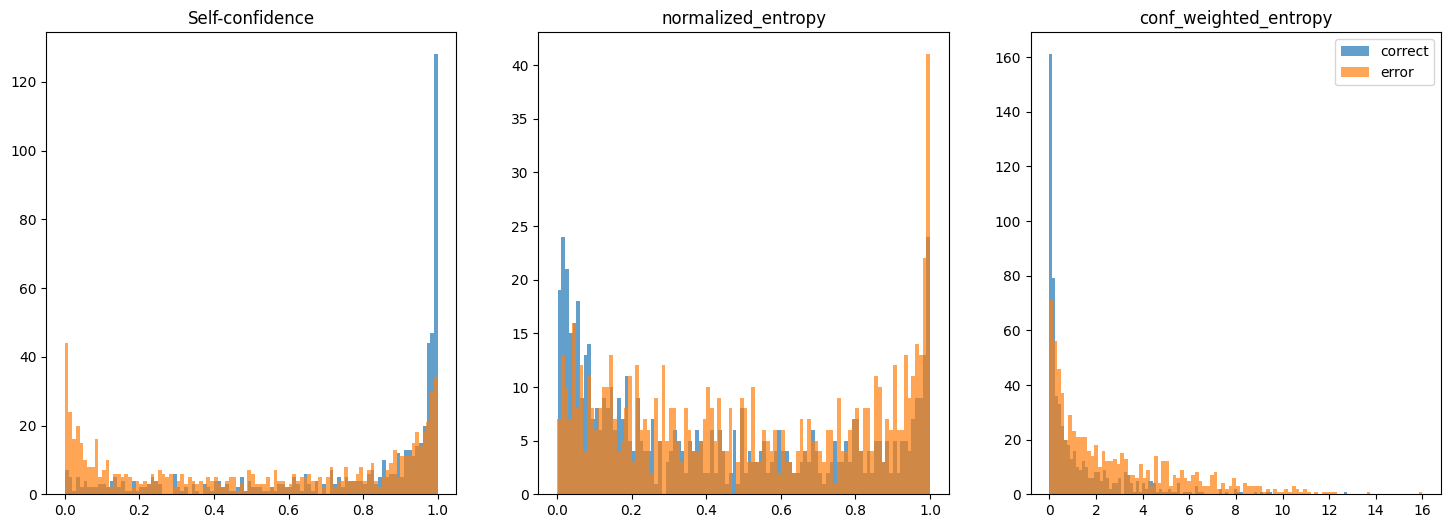

In [29]:
lit_model.to(device)
lit_model.eval()
labels = []
probs = []
with torch.no_grad():
    for batch in tqdm(trace_loader):
        batch = tree_to_device(batch, device)
        logits = lit_model.forward(batch)
        probs.append(torch.softmax(logits, dim=-1).cpu())
        labels.append(batch['label'].cpu())
    probs = torch.concat(probs).numpy()
    labels = torch.concat(labels).numpy()

normalized_entropy = get_normalized_entropy(probs)
self_confidence = torch.tensor(get_self_confidence_for_each_label(labels, probs))
conf_weighted_entropy = normalized_entropy / self_confidence

fig, axes = plt.subplots(1,3, figsize=(18, 6))
axes[0].hist(self_confidence[~true_error_labels], bins=100, label='correct', alpha=0.7)
axes[0].hist(self_confidence[true_error_labels], bins=100, label='error', alpha=0.7)
axes[0].set_title("Self-confidence")
axes[1].hist(normalized_entropy[~true_error_labels], bins=100, label='correct', alpha=0.7)
axes[1].hist(normalized_entropy[true_error_labels], bins=100, label='error', alpha=0.7)
axes[1].set_title("normalized_entropy")
axes[2].hist(conf_weighted_entropy[~true_error_labels], bins=100, label='correct', alpha=0.7)
axes[2].hist(conf_weighted_entropy[true_error_labels], bins=100, label='error', alpha=0.7)
axes[2].set_title("conf_weighted_entropy")
plt.legend()

In [23]:
del trainer
trainer = pl.Trainer(callbacks=[FeatureExtractorFreezeUnfreeze()], enable_checkpointing=False, max_epochs=5, accelerator="gpu", devices=1, logger=False)
trainer.fit(lit_model, train_dataloaders=new_train_dataloader,val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name           | Type               | Params
------------------------------------------------------
0 | net            | BertClassifier     | 109 M 
1 | loss_fn        | CrossEntropyLoss   | 0     
2 | train_accuracy | MulticlassAccuracy | 0     
3 | val_accuracy   | MulticlassAccuracy | 0     
4 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
1.5 K     Trainable params
109 M     Non-trainable params
109 M     Total params
437.935   Total estimated model params size (MB)


Epoch 4: 100%|██████████| 236/236 [00:28<00:00,  8.24it/s, loss=0.216, val/loss=0.296, val/acc=0.879, train/acc_epoch=0.904]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 236/236 [00:28<00:00,  8.24it/s, loss=0.216, val/loss=0.296, val/acc=0.879, train/acc_epoch=0.904]


100%|██████████| 21/21 [00:01<00:00, 10.50it/s]


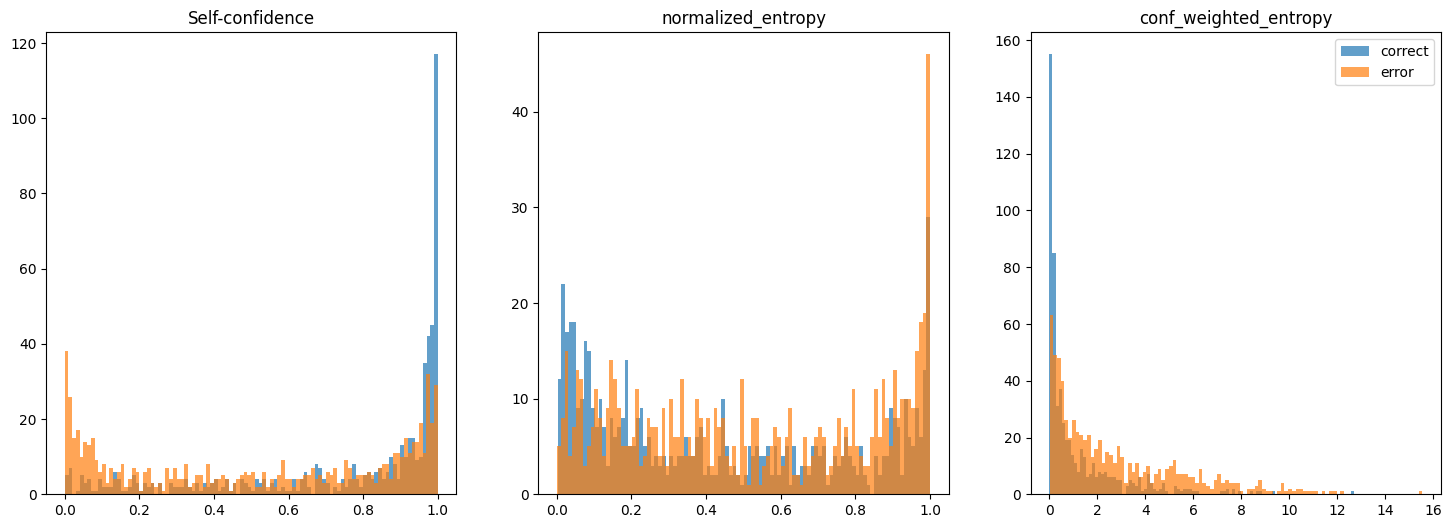

In [24]:
lit_model.to(device)
lit_model.eval()
labels = []
probs = []
with torch.no_grad():
    for batch in tqdm(trace_loader):
        batch = tree_to_device(batch, device)
        logits = lit_model.forward(batch)
        probs.append(torch.softmax(logits, dim=-1).cpu())
        labels.append(batch['label'].cpu())
    probs = torch.concat(probs).numpy()
    labels = torch.concat(labels).numpy()

normalized_entropy = get_normalized_entropy(probs)
self_confidence = torch.tensor(get_self_confidence_for_each_label(labels, probs))
conf_weighted_entropy = normalized_entropy / self_confidence

fig, axes = plt.subplots(1,3, figsize=(18, 6))
axes[0].hist(self_confidence[~true_error_labels], bins=100, label='correct', alpha=0.7)
axes[0].hist(self_confidence[true_error_labels], bins=100, label='error', alpha=0.7)
axes[0].set_title("Self-confidence")
axes[1].hist(normalized_entropy[~true_error_labels], bins=100, label='correct', alpha=0.7)
axes[1].hist(normalized_entropy[true_error_labels], bins=100, label='error', alpha=0.7)
axes[1].set_title("normalized_entropy")
axes[2].hist(conf_weighted_entropy[~true_error_labels], bins=100, label='correct', alpha=0.7)
axes[2].hist(conf_weighted_entropy[true_error_labels], bins=100, label='error', alpha=0.7)
axes[2].set_title("conf_weighted_entropy")
plt.legend()

In [34]:
trainer = pl.Trainer(callbacks=[FeatureExtractorFreezeUnfreeze()], enable_checkpointing=False, max_epochs=20, accelerator="gpu", devices=1, logger=False)
trainer.fit(lit_model, train_dataloaders=new_train_dataloader,val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name           | Type               | Params
------------------------------------------------------
0 | net            | BertClassifier     | 109 M 
1 | loss_fn        | CrossEntropyLoss   | 0     
2 | train_accuracy | MulticlassAccuracy | 0     
3 | val_accuracy   | MulticlassAccuracy | 0     
4 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
1.5 K     Trainable params
109 M     Non-trainable params
109 M     Total params
437.935   Total estimated model params size (MB)


Epoch 19: 100%|██████████| 236/236 [00:28<00:00,  8.19it/s, loss=0.239, val/loss=0.290, val/acc=0.880, train/acc_epoch=0.910]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 236/236 [00:28<00:00,  8.19it/s, loss=0.239, val/loss=0.290, val/acc=0.880, train/acc_epoch=0.910]


100%|██████████| 21/21 [00:01<00:00, 10.50it/s]


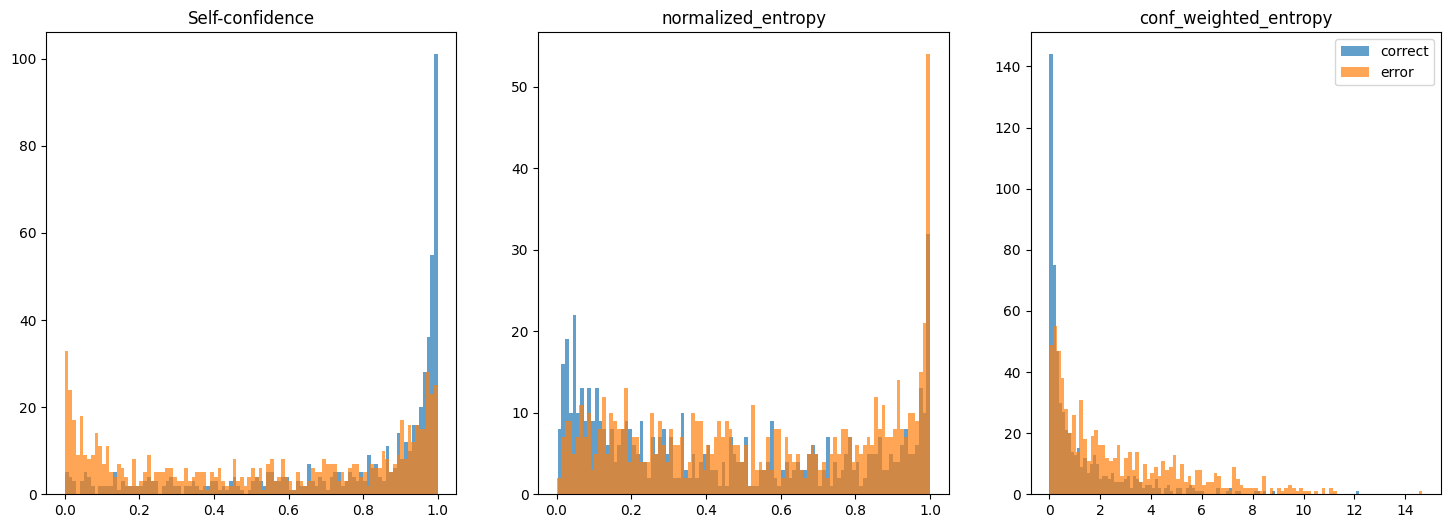

In [35]:
lit_model.to(device)
lit_model.eval()
labels = []
probs = []
with torch.no_grad():
    for batch in tqdm(trace_loader):
        batch = tree_to_device(batch, device)
        logits = lit_model.forward(batch)
        probs.append(torch.softmax(logits, dim=-1).cpu())
        labels.append(batch['label'].cpu())
    probs = torch.concat(probs).numpy()
    labels = torch.concat(labels).numpy()

normalized_entropy = get_normalized_entropy(probs)
self_confidence = torch.tensor(get_self_confidence_for_each_label(labels, probs))
conf_weighted_entropy = normalized_entropy / self_confidence

fig, axes = plt.subplots(1,3, figsize=(18, 6))
axes[0].hist(self_confidence[~true_error_labels], bins=100, label='correct', alpha=0.7)
axes[0].hist(self_confidence[true_error_labels], bins=100, label='error', alpha=0.7)
axes[0].set_title("Self-confidence")
axes[1].hist(normalized_entropy[~true_error_labels], bins=100, label='correct', alpha=0.7)
axes[1].hist(normalized_entropy[true_error_labels], bins=100, label='error', alpha=0.7)
axes[1].set_title("normalized_entropy")
axes[2].hist(conf_weighted_entropy[~true_error_labels], bins=100, label='correct', alpha=0.7)
axes[2].hist(conf_weighted_entropy[true_error_labels], bins=100, label='error', alpha=0.7)
axes[2].set_title("conf_weighted_entropy")
plt.legend()

# pNML

In [17]:
import torch
import torch.nn.functional as F
import numpy as np
import numpy as np

In [18]:
lit_model.load_state_dict(checkpoint["state_dict"])
lit_model.to(device)
lit_model.eval()
labels = []
probs = []
with torch.no_grad():
    for batch in tqdm(trace_loader):
        batch = tree_to_device(batch, device)
        logits = lit_model.forward(batch)
        probs.append(torch.softmax(logits, dim=-1).cpu())
        labels.append(batch['label'].cpu())
    probs = torch.concat(probs).numpy()
    labels = torch.concat(labels).numpy()
self_confidence = torch.tensor(get_self_confidence_for_each_label(labels, probs))
self_acc, _, _ = cal_precision_top(self_confidence, true_error_labels, range(50, 1310, 50), descending=False)

100%|██████████| 21/21 [00:01<00:00, 10.50it/s]


In [1]:
lit_model.load_state_dict(checkpoint["state_dict"])
lit_model.to(device)
lit_model.eval()
with torch.no_grad():
    outputs = []
    ref_outputs = []
    for i, batch in tqdm(enumerate(dm.train_dataloader(shuffle=True))):
        batch = tree_to_device(batch, device)
        b_features = lit_model.feature(batch)
        probs = torch.softmax(lit_model(batch), dim=-1)
        if i < 5:
            outputs.append((probs, b_features))
        elif i < 20:
            ref_outputs.append((probs, b_features, batch["label"]))
        else:
            break
    probs, b_features = zip(*outputs)
    probs = torch.vstack(probs)
    features = torch.vstack(b_features)
x_t_x = torch.matmul(features.t(), features)
_, s, _ = torch.svd(x_t_x, compute_uv=False)

x_t_x = x_t_x
x_t_x_inv = torch.linalg.pinv(
    x_t_x, hermitian=False, rcond=1e-15 
)

NameError: name 'lit_model' is not defined

In [84]:
ref_probs, ref_features, ref_label = zip(*ref_outputs)
ref_features = torch.vstack(ref_features)
ref_probs = torch.vstack(ref_probs)

In [92]:
regrets = []
n_classes = probs.shape[-1]
with torch.no_grad():
    for batch in tqdm(dm.trace_dataloader()):
        batch = tree_to_device(batch, device)
        b_features = lit_model.feature(batch)
        labels = batch["label"]
        probs = torch.softmax(lit_model(batch), dim=-1)
        x_proj = torch.abs(
            torch.matmul(
                torch.matmul(b_features.unsqueeze(1), x_t_x_inv),
                b_features.unsqueeze(-1),
            ).squeeze(-1)
        )
        x_t_g = x_proj / (1 + x_proj)

        # Compute the normalization factor
        nf = probs / (probs + (1 - probs) * (probs ** x_t_g))
        nf = nf - probs
        nf = nf[torch.arange(0, nf.shape[0]), labels]
        # regrets.append((nf/ torch.log(torch.tensor(n_classes)).cpu()))
        regrets.append(nf)


100%|██████████| 21/21 [00:04<00:00,  5.08it/s]


In [93]:
regrets = torch.cat(regrets, dim=0)
regrets = regrets.cpu().squeeze()

In [94]:
regrets

tensor([4.0425e-01, 2.8552e-01, 4.5978e-01,  ..., 4.3103e-03, 2.7418e-06,
        5.3406e-05])

In [95]:
acc, label_ranking, _ = cal_precision_top(regrets, true_error_labels, range(50, 1310, 50), descending=True)

In [ ]:
7,SC_GC,92.00000166893005,83.99999737739563,83.33333134651184,81.00000023841858,78.39999794960022,77.33333110809326,76.57142877578735,74.50000047683716,71.77777886390686,70.59999704360962,69.6363627910614,68.99999976158142,68.30769181251526,68.14285516738892,67.33333468437195,66.25000238418579,65.5294120311737,65.3333306312561,64.10526037216187,63.099998235702515,62.00000047683716,60.90909242630005,59.65217351913452,58.24999809265137,56.80000185966492,55.61538338661194


In [96]:
acc

[83.99999737739563,
 85.00000238418579,
 84.6666693687439,
 82.99999833106995,
 77.99999713897705,
 76.99999809265137,
 75.71428418159485,
 74.75000023841858,
 72.66666889190674,
 72.60000109672546,
 71.63636088371277,
 70.83333134651184,
 69.69230771064758,
 68.85714530944824,
 67.73333549499512,
 67.12499856948853,
 65.76470732688904,
 65.2222216129303,
 64.73684310913086,
 63.599997758865356,
 62.47618794441223,
 61.36363744735718,
 59.913045167922974,
 58.74999761581421,
 57.35999941825867,
 55.69230914115906]

In [71]:
acc

[72.00000286102295,
 69.9999988079071,
 69.33333277702332,
 68.50000023841858,
 66.79999828338623,
 67.33333468437195,
 68.00000071525574,
 68.99999976158142,
 69.33333277702332,
 69.40000057220459,
 69.81818079948425,
 70.16666531562805,
 69.07692551612854,
 68.28571557998657,
 67.1999990940094,
 66.62499904632568,
 65.5294120311737,
 65.11111259460449,
 64.10526037216187,
 63.599997758865356,
 62.57143020629883,
 61.36363744735718,
 60.00000238418579,
 58.74999761581421,
 57.440000772476196,
 55.69230914115906]

In [55]:
acc

[83.99999737739563,
 81.99999928474426,
 80.0000011920929,
 80.50000071525574,
 77.20000147819519,
 76.66666507720947,
 74.85714554786682,
 73.50000143051147,
 72.22222089767456,
 72.00000286102295,
 71.81817889213562,
 71.49999737739563,
 69.9999988079071,
 68.99999976158142,
 67.73333549499512,
 66.75000190734863,
 65.64705967903137,
 64.7777795791626,
 64.5263135433197,
 63.599997758865356,
 62.47618794441223,
 61.4545464515686,
 59.913045167922974,
 58.74999761581421,
 57.35999941825867,
 55.69230914115906]

In [56]:
torch.tensor(acc) - torch.tensor(self_acc)

tensor([-4.0000, -4.0000, -4.0000, -3.5000, -2.4000, -0.3333, -1.4286, -1.7500,
        -0.8889, -0.8000,  0.1818,  0.6667,  0.3077,  0.1429,  0.0000, -0.5000,
        -0.1177, -0.3333, -0.2105,  0.1000,  0.0000,  0.1818,  0.0000,  0.0000,
         0.0000,  0.0000])

In [79]:
acc

[87.99999952316284,
 87.00000047683716,
 83.99999737739563,
 84.50000286102295,
 78.79999876022339,
 77.33333110809326,
 76.28571391105652,
 75.24999976158142,
 73.11111092567444,
 72.60000109672546,
 71.63636088371277,
 70.6666648387909,
 69.69230771064758,
 68.99999976158142,
 67.73333549499512,
 67.25000143051147,
 65.76470732688904,
 65.11111259460449,
 64.73684310913086,
 63.499999046325684,
 62.47618794441223,
 61.27272844314575,
 59.913045167922974,
 58.74999761581421,
 57.35999941825867,
 55.69230914115906]

## Comparation

In [14]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
colected_ks = list(range(50, 1001, 10))
sel_sizes = list(range(50, 1310, 50))
ckpt_path = "outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=09_val_acc=0.8831.ckpt"